请点击[此处](https://ai.baidu.com/docs#/AIStudio_Project_Notebook/a38e5576)查看本环境基本用法.  <br>
Please click [here ](https://ai.baidu.com/docs#/AIStudio_Project_Notebook/a38e5576) for more detailed instructions. 

## Requirement

> * Select one image segmentation method to complete satellite cloud image segmentation(5 images).
> * The objective evaluation is Mean Intersection over Union，MIoU.
> * Try to make your MIoU value greater than 0.5 or higher.

![](https://ai-studio-static-online.cdn.bcebos.com/b915b78edf244e9aa4b86e58e0e20a82155246a78b894b878b560cc01b0a046f)
![](https://ai-studio-static-online.cdn.bcebos.com/f60d42bb55fb4cc0835baca31515f3b08e68d9a9f13c4913ac844218aaaee24a)



### 第一次提交说明

本次作业主要调试不同分割方法，并且熟悉交并比$I o U=\frac{A \cap B}{A \cup B}$等一些公式的学习

* 本次作业共使用四种方法，
  * 使用OTSU阈值方法 
  * 使用自适应方法  
  * 使用区域生长方法  
  * 使用K-means方法
* 第一次提交，虽然这个点打的看起来不咋样，但是把方法给跑通了。而且这个k-means这次跑的铁有问题，因为都是0。。
* 期待第二次提交

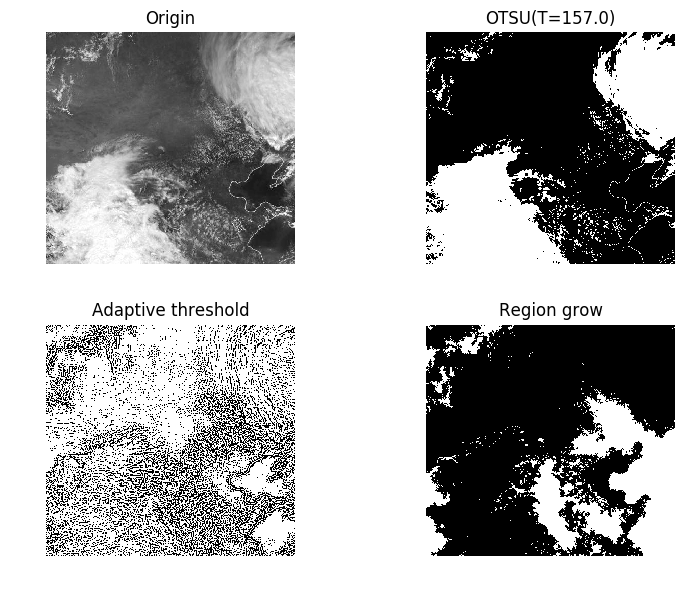

In [25]:
# 区域分割
import cv2
import matplotlib.pyplot as plt 
import numpy as np


## 图像分割之区域生长

# 求两个像素的距离
def getGrayDiff(image, currentPoint, tmpPoint):  
    return abs(int(image[currentPoint[0], currentPoint[1]]) - int(image[tmpPoint[0], tmpPoint[1]]))

# 区域生长算法
def regional_growth(img, seeds, thresh=5):
    height, weight = img.shape
    seedMark = np.zeros(img.shape)
    seedList = []
    for seed in seeds:
        if (0<seed[0]<height and 0<seed[1]<weight): seedList.append(seed)
    # 种子位置标记    
    label = 1  # 种子位置标记
    # 8 邻接连通
    connects = [(-1,-1), (0,-1), (1,-1), (1,0), (1,1), (0,1), (-1,1), (-1,0)] 
    # 如果列表里还存在点
    while (len(seedList) > 0): 
        # 将最前面的那个抛出
        currentPoint = seedList.pop(0) 
        # 将对应位置的点标记为 1
        seedMark[currentPoint[0], currentPoint[1]] = label 
        # 对这个点周围的8个点一次进行相似性判断 
        for i in range(8): 
            tmpX = currentPoint[0] + connects[i][0]
            tmpY = currentPoint[1] + connects[i][1]
            # 是否超出限定阈值
            if tmpX<0 or tmpY<0 or tmpX>=height or tmpY>=weight: 
                continue
             # 计算灰度差
            grayDiff = getGrayDiff(img, currentPoint, (tmpX, tmpY)) 
            if grayDiff<thresh and seedMark[tmpX,tmpY]==0:
                seedMark[tmpX, tmpY] = label
                seedList.append((tmpX, tmpY))
    return seedMark


# 区域生长
img = cv2.imread("data/5.jpg", flags=0)
# # 灰度直方图
# histCV = cv2.calcHist([img], [0], None, [256], [0, 256]) 
# OTSU 全局阈值处理
ret, imgOtsu = cv2.threshold(img, 127, 255, cv2.THRESH_OTSU) 
# 自适应局部阈值处理
binaryMean = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 5, 3)
# 区域生长图像分割
# seeds = [(10, 10), (82, 150), (20, 300)]  
imgBlur = cv2.blur(img, (3,3))  
_, imgTop = cv2.threshold(imgBlur, 250, 255, cv2.THRESH_BINARY)  
 # 过滤连通域，获得质心点 (x,y)
nseeds, labels, stats, centroids = cv2.connectedComponentsWithStats(imgTop)  
# 获得质心像素作为种子点
seeds = centroids.astype(int) 
imgGrowth = regional_growth(img, seeds, 8)

plt.figure(figsize=(8, 6))
plt.subplot(221), plt.axis('off'), plt.title("Origin")
plt.imshow(img, 'gray')
plt.subplot(222), plt.axis('off'), plt.title("OTSU(T={})".format(ret))
plt.imshow(imgOtsu, 'gray')
plt.subplot(223), plt.axis('off'), plt.title("Adaptive threshold")
plt.imshow(binaryMean, 'gray')
plt.subplot(224), plt.axis('off'), plt.title("Region grow")
plt.imshow(255-imgGrowth, 'gray')
plt.tight_layout()
plt.show()

### 一、阈值分析

#### 方法一：使用OTSU阈值方法进行

In [2]:
# OTSU
# 区域分割
import cv2
import matplotlib.pyplot as plt 
import numpy as np

img_original_list = []
img_result_list = []
for i in range(5):
    img = cv2.imread("data/{}.jpg".format(int(i+1)), flags=0)
    img_original_list.append(img)
    # OTSU 全局阈值处理
    ret, imgOtsu = cv2.threshold(img, 127, 255, cv2.THRESH_OTSU)
    # ret是返回的最优阈值，imgOtsu 返回的是图像
    # cv2.threshold(输入图像,设定阈值a,大于阈值a变成的最大的数b, cv2.THRESH_OTSU)   大于阈值a的变成b，小于阈值的变成0
    img_result = imgOtsu
    img_result_list.append(img_result)

for i in range(len(img_result_list)):
    cv2.imwrite("./data/result/{}.png".format(int(i+1)),img_result_list[i])

# plt.figure(figsize=(8, 6))
# plt.subplot(221), plt.axis('off'), plt.title("Origin")
# plt.imshow(img, 'gray')
# plt.subplot(222), plt.axis('off'), plt.title("OTSU(T={})".format(ret))
# plt.imshow(imgOtsu, 'gray')



In [5]:
import cv2
import numpy as np
import os
import sys
import matplotlib.pyplot as plt

# 分割结果图片存入文件夹“result”，
# 标签图片存入文件夹“label”

Label_file_path = './data/label'
StuResult_file_path = './data/result'



'''compute IOUs '''
Label_file_name = os.listdir(Label_file_path)
Label_file_name.sort(key=lambda x:int(x[:-4]))
print(Label_file_name)


StuResult_file_name = os.listdir(StuResult_file_path)
StuResult_file_name.sort(key=lambda x:int(x[:-4]))
print(StuResult_file_name)

IOU = []
for i in range(5):
    img1=cv2.imread(Label_file_path+'/'+Label_file_name[i],0)
    # img1=cv2.resize(img1,(512,512))
    img2=cv2.imread(StuResult_file_path+'/'+StuResult_file_name[i],0)
    # img2 = cv2.resize(img2, (512, 512))
    And_pixels=0
    Or_pixels=0
    for i in range(img1.shape[0]):
        for j in range(img1.shape[1]):
            if img1[i,j]==255 or img2[i,j]==255:
                Or_pixels+=1
            if img1[i,j]==255 and img2[i,j]==255:
                And_pixels+=1
    IOU.append(And_pixels/Or_pixels)

average_IOU = np.mean(IOU)
print("score = ", IOU)
print("average score = ", average_IOU)

['1.png', '2.png', '3.png', '4.png', '5.png']
['1.png', '2.png', '3.png', '4.png', '5.png']
score =  [0.7535072228213022, 0.6288888710750559, 0.6700293995212822, 0.4594807666168275, 0.5744251525105584]
average score =  0.6172662825090052


### 二、区域分割

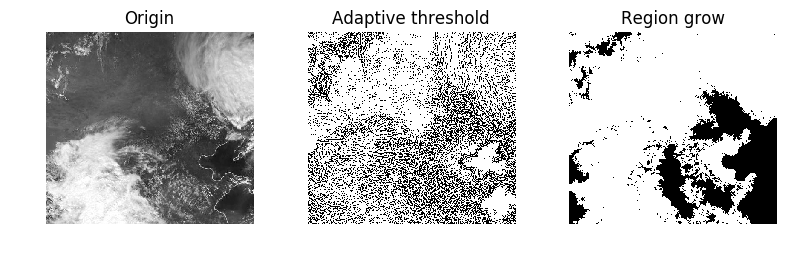

In [44]:
# 区域分割
import cv2
import matplotlib.pyplot as plt 
import numpy as np


## 图像分割之区域生长

# 求两个像素的距离
def getGrayDiff(image, currentPoint, tmpPoint):  
    return abs(int(image[currentPoint[0], currentPoint[1]]) - int(image[tmpPoint[0], tmpPoint[1]]))

# 区域生长算法
def regional_growth(img, seeds, thresh=5):
    height, weight = img.shape
    seedMark = np.zeros(img.shape)
    seedList = []
    for seed in seeds:
        if (0<seed[0]<height and 0<seed[1]<weight): seedList.append(seed)
    # 种子位置标记    
    label = 1  # 种子位置标记
    # 8 邻接连通
    connects = [(-1,-1), (0,-1), (1,-1), (1,0), (1,1), (0,1), (-1,1), (-1,0)] 
    # 如果列表里还存在点
    while (len(seedList) > 0): 
        # 将最前面的那个抛出
        currentPoint = seedList.pop(0) 
        # 将对应位置的点标记为 1
        seedMark[currentPoint[0], currentPoint[1]] = label 
        # 对这个点周围的8个点一次进行相似性判断 
        for i in range(8): 
            tmpX = currentPoint[0] + connects[i][0]
            tmpY = currentPoint[1] + connects[i][1]
            # 是否超出限定阈值
            if tmpX<0 or tmpY<0 or tmpX>=height or tmpY>=weight: 
                continue
             # 计算灰度差
            grayDiff = getGrayDiff(img, currentPoint, (tmpX, tmpY)) 
            if grayDiff<thresh and seedMark[tmpX,tmpY]==0:
                seedMark[tmpX, tmpY] = label
                seedList.append((tmpX, tmpY))
    return seedMark


# 区域生长
img = cv2.imread("data/5.jpg", flags=0)
# # 灰度直方图
# histCV = cv2.calcHist([img], [0], None, [256], [0, 256]) 
# OTSU 全局阈值处理
# ret, imgOtsu = cv2.threshold(img, 127, 255, cv2.THRESH_OTSU) 
# 自适应局部阈值处理
binaryMean = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 5, 3)
# 区域生长图像分割
# seeds = [(10, 10), (82, 150), (20, 300)]  
imgBlur = cv2.blur(img, (3,3))  
_, imgTop = cv2.threshold(imgBlur, 250, 255, cv2.THRESH_BINARY)  
 # 过滤连通域，获得质心点 (x,y)
nseeds, labels, stats, centroids = cv2.connectedComponentsWithStats(imgTop)  
# 获得质心像素作为种子点
seeds = centroids.astype(int) 
imgGrowth = regional_growth(img, seeds, 8)

plt.figure(figsize=(8, 6))
plt.subplot(131), plt.axis('off'), plt.title("Origin")
plt.imshow(img, 'gray')
# plt.subplot(222), plt.axis('off'), plt.title("OTSU(T={})".format(ret))
# plt.imshow(imgOtsu, 'gray')
plt.subplot(132), plt.axis('off'), plt.title("Adaptive threshold")
plt.imshow(binaryMean, 'gray')
plt.subplot(133), plt.axis('off'), plt.title("Region grow")
plt.imshow(imgGrowth, 'gray')
plt.tight_layout()
plt.show()

#### 方法二：使用自适应的方法

In [41]:
# 自适应方法
# 区域分割
import cv2
import matplotlib.pyplot as plt 
import numpy as np

img_original_list = []
img_result_list = []
for i in range(5):
    img = cv2.imread("data/{}.jpg".format(int(i+1)), flags=0)
    img_original_list.append(img)
    # 自适应局部阈值处理
    binaryMean = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 5, 3)
    img_result = binaryMean
    img_result_list.append(img_result)

for i in range(len(img_result_list)):
    cv2.imwrite("./data/result_adaptive/{}.png".format(int(i+1)),img_result_list[i])

# plt.figure(figsize=(8, 6))
# plt.subplot(221), plt.axis('off'), plt.title("Origin")
# plt.imshow(img, 'gray')
# plt.subplot(222), plt.axis('off'), plt.title("OTSU(T={})".format(ret))
# plt.imshow(imgOtsu, 'gray')


In [ ]:
import cv2
import numpy as np
import os
import sys
import matplotlib.pyplot as plt

# 分割结果图片存入文件夹“result”，
# 标签图片存入文件夹“label”

Label_file_path = './data/label'
StuResult_file_path = './data/result_adaptive'


'''compute IOUs '''
Label_file_name = os.listdir(Label_file_path)
Label_file_name.sort(key=lambda x:int(x[:-4]))
print(Label_file_name)


StuResult_file_name = os.listdir(StuResult_file_path)
StuResult_file_name.sort(key=lambda x:int(x[:-4]))
print(StuResult_file_name)

IOU = []
for i in range(5):
    img1=cv2.imread(Label_file_path+'/'+Label_file_name[i],0)
    # img1=cv2.resize(img1,(512,512))
    img2=cv2.imread(StuResult_file_path+'/'+StuResult_file_name[i],0)
    # img2 = cv2.resize(img2, (512, 512))
    And_pixels=0
    Or_pixels=0
    for i in range(img1.shape[0]):
        for j in range(img1.shape[1]):
            if img1[i,j]==255 or img2[i,j]==255:
                Or_pixels+=1
            if img1[i,j]==255 and img2[i,j]==255:
                And_pixels+=1
    IOU.append(And_pixels/Or_pixels)

average_IOU = np.mean(IOU)
print("score = ", IOU)
print("average score = ", average_IOU)

![](https://ai-studio-static-online.cdn.bcebos.com/8e3ae7b3f0374eb9b8e6a2be4c4e4db42e54cdcb6dcb4e9b832a273c507c9491)


#### 方法三：使用区域生长的方法

In [93]:
# 区域分割
import cv2
import matplotlib.pyplot as plt 
import numpy as np


## 图像分割之区域生长

# 求两个像素的距离
def getGrayDiff(image, currentPoint, tmpPoint):  
    return abs(int(image[currentPoint[0], currentPoint[1]]) - int(image[tmpPoint[0], tmpPoint[1]]))

# 区域生长算法
def regional_growth(img, seeds, thresh=5):
    height, weight = img.shape
    seedMark = np.zeros(img.shape)
    seedList = []
    for seed in seeds:
        if (0<seed[0]<height and 0<seed[1]<weight): seedList.append(seed)
    # 种子位置标记    
    label = 1  # 种子位置标记
    # 8 邻接连通
    connects = [(-1,-1), (0,-1), (1,-1), (1,0), (1,1), (0,1), (-1,1), (-1,0)] 
    # 如果列表里还存在点
    while (len(seedList) > 0): 
        # 将最前面的那个抛出
        currentPoint = seedList.pop(0) 
        # 将对应位置的点标记为 1
        seedMark[currentPoint[0], currentPoint[1]] = label 
        # 对这个点周围的8个点一次进行相似性判断 
        for i in range(8): 
            tmpX = currentPoint[0] + connects[i][0]
            tmpY = currentPoint[1] + connects[i][1]
            # 是否超出限定阈值
            if tmpX<0 or tmpY<0 or tmpX>=height or tmpY>=weight: 
                continue
             # 计算灰度差
            grayDiff = getGrayDiff(img, currentPoint, (tmpX, tmpY)) 
            if grayDiff<thresh and seedMark[tmpX,tmpY]==0:
                seedMark[tmpX, tmpY] = label
                seedList.append((tmpX, tmpY))
    return seedMark


# 区域生长
img = cv2.imread("data/5.jpg", flags=0)
# 区域生长图像分割
# seeds = [(10, 10), (82, 150), (20, 300)]  
imgBlur = cv2.blur(img, (3,3))  
_, imgTop = cv2.threshold(imgBlur, 250, 255, cv2.THRESH_BINARY)  
 # 过滤连通域，获得质心点 (x,y)
nseeds, labels, stats, centroids = cv2.connectedComponentsWithStats(imgTop)  
# 获得质心像素作为种子点
seeds = centroids.astype(int) 

imgGrowth = regional_growth(img, seeds,7)

imgGrowth = imgGrowth.astype(np.uint8)
# plt.imshow(imgGrowth,"gray")
cv2.imwrite("./data/result_growing/10.jpg",imgGrowth)

True

In [74]:
# 区域生长
# 区域分割
import cv2
import matplotlib.pyplot as plt 
import numpy as np

img_original_list = []
img_result_list = []
for i in range(5):
    img = cv2.imread("data/{}.jpg".format(int(i+1)), flags=0)
    img_original_list.append(img)

    # 获得质心像素作为种子点
    seeds = centroids.astype(int) 
    imgGrowth = regional_growth(img, seeds, 8)
    imgGrowth_new = cv2.normalize(imgGrowth, None, 255,0, cv2.NORM_MINMAX, cv2.CV_8UC1)

    img_result = imgGrowth_new
    img_result_list.append(img_result)

for i in range(len(img_result_list)):
    cv2.imwrite("./data/result_growing/{}.png".format(int(i+1)),img_result_list[i])

# plt.figure(figsize=(8, 6))
# plt.subplot(221), plt.axis('off'), plt.title("Origin")
# plt.imshow(img, 'gray')
# plt.subplot(222), plt.axis('off'), plt.title("OTSU(T={})".format(ret))
# plt.imshow(imgOtsu, 'gray')

In [75]:
import cv2
import numpy as np
import os
import sys
import matplotlib.pyplot as plt

# 分割结果图片存入文件夹“result”，
# 标签图片存入文件夹“label”

Label_file_path = './data/label'
StuResult_file_path = './data/result_growing'


'''compute IOUs '''
Label_file_name = os.listdir(Label_file_path)
Label_file_name.sort(key=lambda x:int(x[:-4]))
print(Label_file_name)


StuResult_file_name = os.listdir(StuResult_file_path)
StuResult_file_name.sort(key=lambda x:int(x[:-4]))
print(StuResult_file_name)

IOU = []
for i in range(5):
    img1=cv2.imread(Label_file_path+'/'+Label_file_name[i],0)
    # img1=cv2.resize(img1,(512,512))
    img2=cv2.imread(StuResult_file_path+'/'+StuResult_file_name[i],0)
    # img2 = cv2.resize(img2, (512, 512))
    And_pixels=0
    Or_pixels=0
    for i in range(img1.shape[0]):
        for j in range(img1.shape[1]):
            if img1[i,j]==255 or img2[i,j]==255:
                Or_pixels+=1
            if img1[i,j]==255 and img2[i,j]==255:
                And_pixels+=1
    IOU.append(And_pixels/Or_pixels)

average_IOU = np.mean(IOU)
print("score = ", IOU)
print("average score = ", average_IOU)

![](https://ai-studio-static-online.cdn.bcebos.com/84df4696276f423f8f524ffdf03c8ce757bed41931ea47f0a67b499f0eeedee8)


![](https://ai-studio-static-online.cdn.bcebos.com/6fd06cd57e434ba097780470da5e8d9d8ba0d0f66e014e509c32294c7b2aa6e4)


### 三、k-means

#### 方法四：K-means

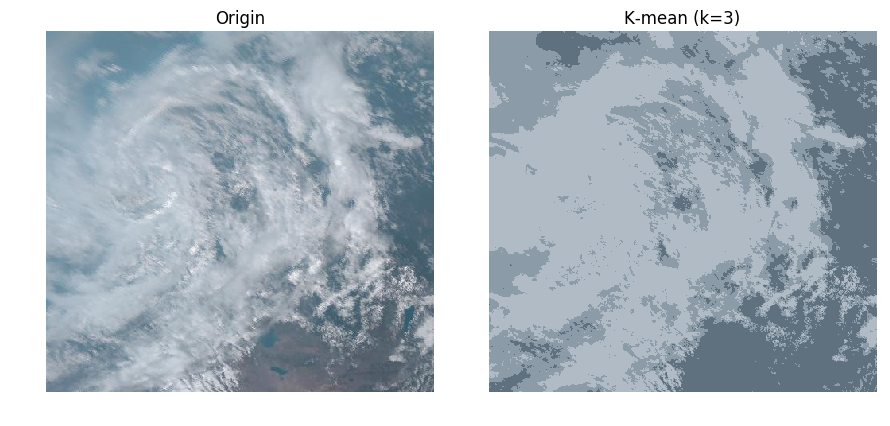

In [89]:
# k-means聚类
# k 均值聚类
import cv2
import matplotlib.pyplot as plt 
import numpy as np


img = cv2.imread("data/1.jpg") 

#此处-1表示行数自动计算
dataPixel = np.float32(img.reshape((-1, 3)))
# 终止条件
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 200, 0.1)  
# 起始的中心选择
flags = cv2.KMEANS_RANDOM_CENTERS  

# 设置聚类数
K = 3  
_, labels, center = cv2.kmeans(dataPixel, K, None, criteria, 10, flags)
centerUint = np.uint8(center)
# 将像素标记为聚类中心颜色
classify = centerUint[labels.flatten()]  
# 恢复为二维图像
imgKmean3 = classify.reshape((img.shape)) 


# display
plt.figure(figsize=(9, 7))
plt.subplot(121), plt.axis('off'), plt.title("Origin")
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))  
plt.subplot(122), plt.axis('off'), plt.title("K-mean (k=3)")
plt.imshow(cv2.cvtColor(imgKmean3, cv2.COLOR_BGR2RGB))
plt.tight_layout()
plt.show()


In [91]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

img_original_list = []
img_result_list = []
for i in range(5):
    img = cv2.imread("data/{}.jpg".format(int(i+1)))
    img_original_list.append(img)
    # kmeans
    # img = cv2.imread("data/2.jpg")

    #此处-1表示行数自动计算
    dataPixel = np.float32(img.reshape((-1, 3)))
    # 终止条件
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 200, 0.1)
    # 起始的中心选择
    flags = cv2.KMEANS_RANDOM_CENTERS

    # 设置聚类数
    K = 3
    _, labels, center = cv2.kmeans(dataPixel, K, None, criteria, 10, flags)
    centerUint = np.uint8(center)
    # 将像素标记为聚类中心颜色
    classify = centerUint[labels.flatten()]
    # 恢复为二维图像
    imgKmean3 = classify.reshape((img.shape))
    imgKmean3_new = cv2.normalize(imgKmean3 , None, 255,0, cv2.NORM_MINMAX, cv2.CV_8UC1)
    img_result = imgKmean3_new
    img_result_list.append(img_result)

for i in range(len(img_result_list)):
    cv2.imwrite("./data/result_kmeans/{}.png".format(int(i+1)),img_result_list[i])



![](https://ai-studio-static-online.cdn.bcebos.com/8bc98747263c4e01bfc31b39373b7c154fec5e6f6b124c98b3c7f5dadce48aa6)
